# We visualize VibVoice+
1. We visualize the frequency distribution of the VibVoice+ datasets.
2. We visualize the correlation between vibration and speech under different conditions.

In [ ]:
import numpy as np
import json
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats  as stats
import scipy.signal as signal


100%|██████████| 2864/2864 [00:05<00:00, 534.71it/s]


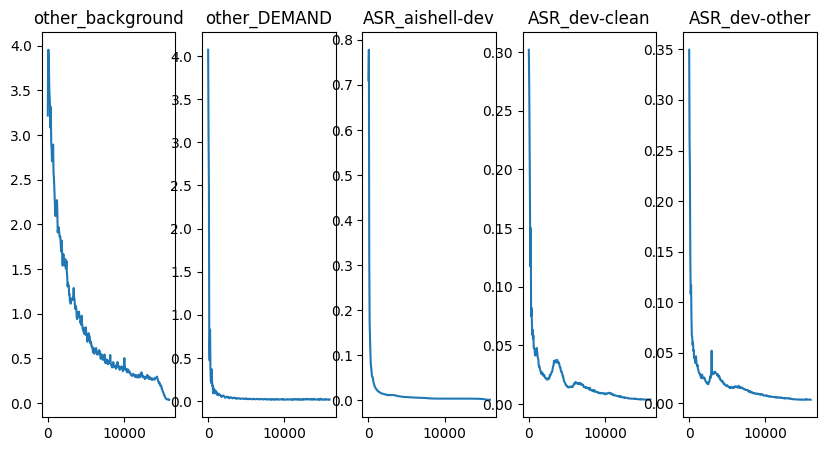

In [3]:
datasets = ['json/other_background.json', 'json/other_DEMAND.json', 'json/ASR_aishell-dev.json', 'json/ASR_dev-clean.json', 'json/ASR_dev-other.json']
fftfreq = np.arange(0, 16000, 16000/320)
fig, axs = plt.subplots(1, len(datasets), figsize=(10, 5))
for i, data in enumerate(datasets):
    files = json.load(open(data, 'r'))
    fft = np.zeros((320, ))
    for tuple in tqdm(files):
        file, _ = tuple 
        noise_new_added, sr = librosa.load(file, sr=None, mono=True)
        fft += np.abs(np.fft.fft(noise_new_added, n=640)[:320])
    fft /= len(files)
    axs[i].plot(fftfreq, fft)
    axs[i].set_title(data[5:-5])
plt.show()

  1%|▏         | 54/3750 [00:00<00:06, 533.48it/s]

100%|██████████| 3750/3750 [00:08<00:00, 435.88it/s]


dBFS of audio is: 34.56993992118783 rms ratio audio/imu is: 1.209176110948815


100%|██████████| 1174/1174 [00:03<00:00, 312.60it/s]


dBFS of audio is: 38.237034963163275 rms ratio audio/imu is: 4.215179962399591


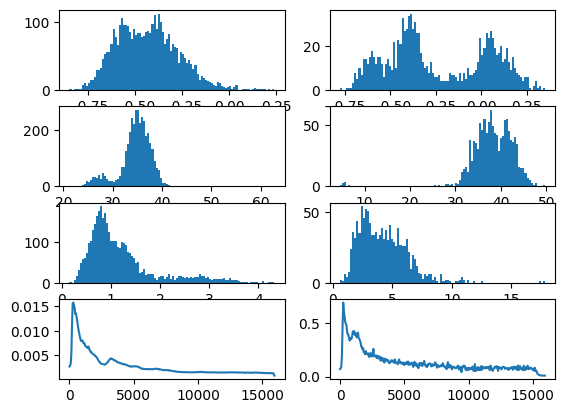

In [5]:

b, a = signal.butter(4, 100, 'highpass', fs=16000)
datasets = [
            'json/ABCS_dev.json', 
            'json/V2S.json',
            ]
fig, axs = plt.subplots(4, len(datasets))
fftfreq = np.arange(0, 16000, 16000/320)

for i, data in enumerate(datasets):
    correlation = []
    RMS = []
    dBFS = []
    files_all = json.load(open(data, 'r'))
    files = []
    if data == 'json/ABCS_dev.json':
        for key in files_all.keys():
            files += files_all[key]
    else:
        for key in files_all.keys():
            for section in files_all[key].keys():
                files += files_all[key][section]
    fft = np.zeros((2, 320, ))
    for file in tqdm(files):
        recording, sr = librosa.load(file[0], sr=None, mono=False)
        recording = signal.filtfilt(b, a, recording)
        rms = np.sqrt(np.mean(recording**2, axis=-1))
        dBFS.append(np.log10(1 / rms) * 20)
        RMS.append(rms)
        pearsonr = stats.pearsonr(recording[0], recording[1])[0]
        correlation.append(pearsonr)
        fft += np.abs(np.fft.fft(recording, n=640, axis=-1)[:, :320])
    fft /= len(files)
    axs[0, i].hist(correlation, bins=100)
    avg_dBFS = np.mean(dBFS, axis=0)
    RMS = np.array(RMS)
    if data == 'json/ABCS_dev.json':
        rms_ratio = RMS[:, 0]/RMS[:, 1]
        print('dBFS of audio is:', avg_dBFS[0], 'rms ratio audio/imu is:', np.mean(rms_ratio))
        axs[1, i].hist(np.array(dBFS)[:, 0], bins=100)
        axs[2, i].hist(rms_ratio, bins=100)
        axs[3, i].plot(fftfreq, fft[0])
    else:
        rms_ratio = RMS[:, 1]/RMS[:, 0]
        print('dBFS of audio is:', avg_dBFS[1], 'rms ratio audio/imu is:', np.mean(rms_ratio))
        axs[1, i].hist(np.array(dBFS)[:, 1], bins=100)
        axs[2, i].hist(rms_ratio, bins=100)
        axs[3, i].plot(fftfreq, fft[1])
plt.show()

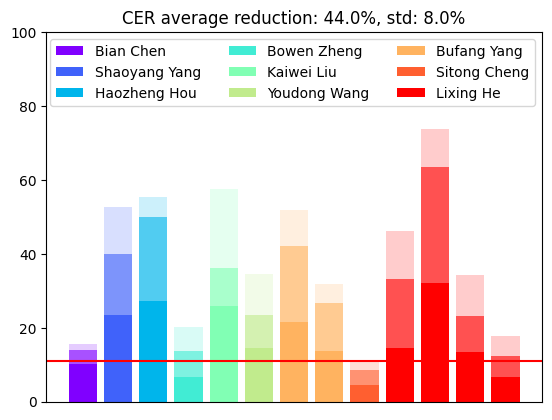

In [10]:
def organize_dict(dictionary):
    new_dict = {}
    for i, key in enumerate(dictionary.keys()):
        speaker = ' '.join(key.split('_')[:2])
        date = key.split('_')[-1]
        if speaker not in new_dict:
            new_dict[speaker] = {date: dictionary[key]}
        else:
            new_dict[speaker][date] = dictionary[key]
    return new_dict
def improvement_ratio(cer1, cer2):
    ratios = []
    for cer1_, cer2_ in zip(cer1.values(), cer2.values()):
        ratios.append((cer1_ - cer2_) / cer1_)
    return np.mean(ratios), np.std(ratios)
inp = {'Bian_Chen_2023-09-07': 15.55, 'Shaoyang_Yang_2023-09-10': 52.62, 'Haozheng_Hou_2023-09-11': 55.35, 'Bowen_Zheng_2023-09-07': 20.06, 'Kaiwei_Liu_2023-09-11': 57.47, 'Youdong_Wang_2023-09-11': 34.44, 'Bufang_Yang_2023-09-09': 51.68, 'Bufang_Yang_2023-09-05': 31.83, 'Sitong_Cheng_2023-09-07': 11.32, 'Lixing_He_2023-09-10': 46.15, 'Lixing_He_2023-09-11': 73.66, 'Lixing_He_2023-09-09': 34.3, 'Lixing_He_2023-09-05': 17.7}

baseline = {'Bian_Chen_2023-09-07': 14.02, 'Shaoyang_Yang_2023-09-10': 39.81, 'Haozheng_Hou_2023-09-11': 49.95, 'Bowen_Zheng_2023-09-07': 13.55, 'Kaiwei_Liu_2023-09-11': 36.11, 'Youdong_Wang_2023-09-11': 23.46, 'Bufang_Yang_2023-09-09': 41.99, 'Bufang_Yang_2023-09-05': 26.62, 'Sitong_Cheng_2023-09-07': 8.6, 'Lixing_He_2023-09-10': 33.17, 'Lixing_He_2023-09-11': 63.5, 'Lixing_He_2023-09-09': 23.08, 'Lixing_He_2023-09-05': 12.44}

vibvoice = {'Bian_Chen_2023-09-07': 10.26, 'Shaoyang_Yang_2023-09-10': 23.5, 'Haozheng_Hou_2023-09-11': 27.17, 'Bowen_Zheng_2023-09-07': 6.73, 'Kaiwei_Liu_2023-09-11': 25.88, 'Youdong_Wang_2023-09-11': 14.56, 'Bufang_Yang_2023-09-09': 21.49, 'Bufang_Yang_2023-09-05': 13.79, 'Sitong_Cheng_2023-09-07': 4.58, 'Lixing_He_2023-09-10': 14.6, 'Lixing_He_2023-09-11': 32.04, 'Lixing_He_2023-09-09': 13.36, 'Lixing_He_2023-09-05': 6.71}

average_improve, std_improve = improvement_ratio(baseline, vibvoice)
inp = organize_dict(inp)
baseline = organize_dict(baseline)
vibvoice = organize_dict(vibvoice)
speaker = ''
dates = []
j = 0
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(vibvoice.keys())))
color_light = color
color_light[:, -1] = 1
for i, speaker in enumerate(vibvoice.keys()):
    dates = inp[speaker].keys()
    cer = inp[speaker].values()
    plt.bar(range(j, j+len(dates)), cer, color=color[i] + np.array([0, 0, 0, -0.8]))
    cer_baseline = baseline[speaker].values()
    plt.bar(range(j, j+len(dates)), cer_baseline, color=color[i] + np.array([0, 0, 0, -0.4]))
    cer_vib = vibvoice[speaker].values()
    plt.bar(range(j, j+len(dates)), cer_vib, color=color[i], label=speaker)
    j += len(dates)
plt.axhline(y=11, color='r', linestyle='-')
plt.ylim(0, 100)
plt.legend(ncol=3)
plt.title('CER average reduction: ' + str(round(average_improve, 2) * 100) + '%, std: ' + str(round(std_improve, 2) * 100) + '%')
plt.xticks([])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


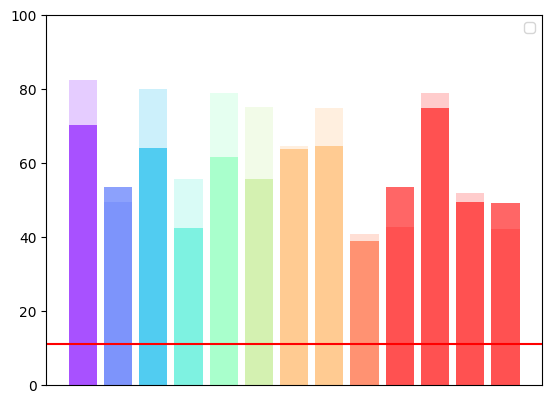

In [5]:
inp = {'Bian_Chen_2023-09-07': 82.51, 'Shaoyang_Yang_2023-09-10': 49.28, 'Haozheng_Hou_2023-09-11': 79.98, 
       'Bowen_Zheng_2023-09-07': 55.56, 'Kaiwei_Liu_2023-09-11': 78.79, 'Youdong_Wang_2023-09-11': 75.1, 'Bufang_Yang_2023-09-09': 64.51, 'Bufang_Yang_2023-09-05': 74.72, 'Sitong_Cheng_2023-09-07': 40.69, 'Lixing_He_2023-09-10': 42.74, 'Lixing_He_2023-09-11': 78.87, 'Lixing_He_2023-09-09': 51.88, 'Lixing_He_2023-09-05': 42.09}

inp = organize_dict(inp)
baseline = organize_dict(baseline)
speaker = ''
dates = []
j = 0
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(vibvoice.keys())))
color_light = color
color_light[:, -1] = 1
for i, speaker in enumerate(vibvoice.keys()):
    
    dates = inp[speaker].keys()
    cer = inp[speaker].values()
    plt.bar(range(j, j+len(dates)), cer, color=color[i] + np.array([0, 0, 0, -0.8]))

    cer_baseline = baseline[speaker].values()
    plt.bar(range(j, j+len(dates)), cer_baseline, color=color[i] + np.array([0, 0, 0, -0.4]))
    j += len(dates)
plt.axhline(y=11, color='r', linestyle='-')
plt.ylim(0, 100)
plt.legend(ncol=3)
plt.xticks([])
plt.show()



  0%|          | 0/1174 [00:00<?, ?it/s]

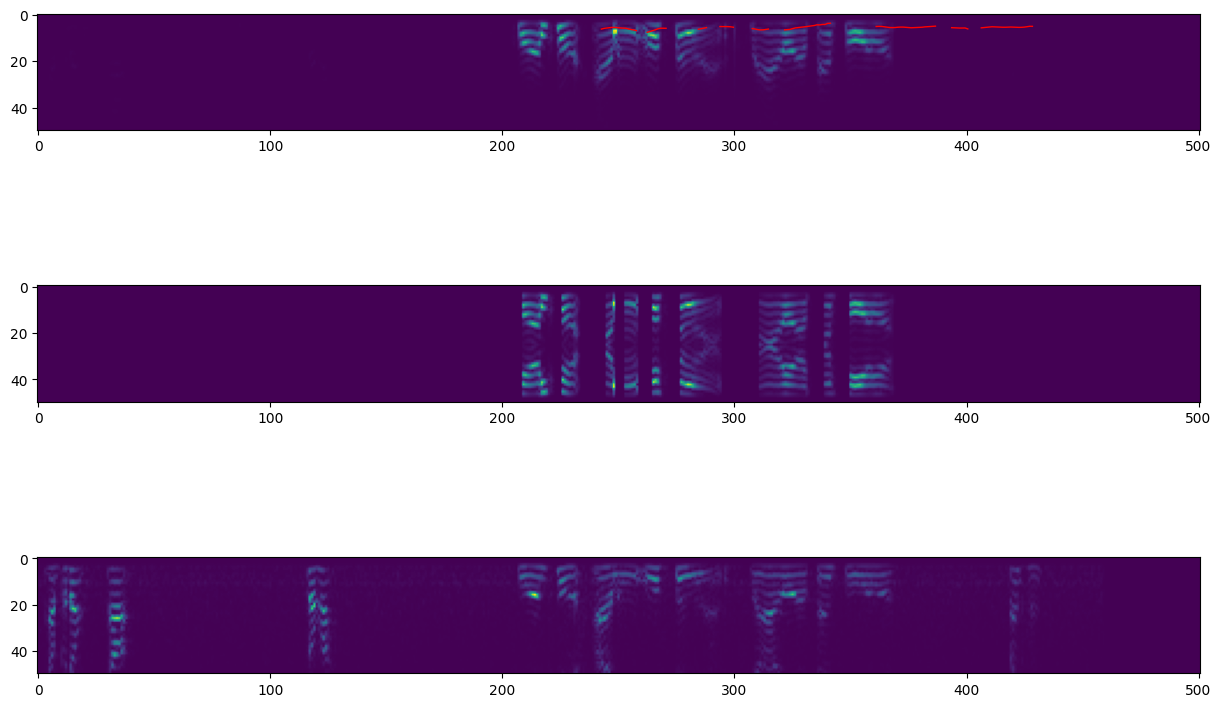

  0%|          | 0/1174 [00:01<?, ?it/s]


In [31]:

'''
We reproduce VoiceListener, IMWUT'23 here
'''
def Aliasing_Correction(stft, pitch):
    def AF(f):
        return abs(f - int(f/50 + 0.5) * 50)
    new_stft = np.zeros_like(stft)
    for t in range(pitch.shape[-1]):
        if np.isnan(pitch[t]):
            continue
        else:
            pitch_t = int(pitch[t] // 50) + 1
        for f in range(50):
            if f > (25):
                if f % pitch_t == 0:
                    new_stft[f, t] = stft[AF(f), t]
            else:
                if f % pitch_t == 0:
                    new_stft[f, t] = stft[f, t]
    return new_stft
b, a = signal.butter(4, 100, 'highpass', fs=16000)
datasets = [
            'json/V2S.json',
            ]
for i, data in enumerate(datasets):
    correlation = []
    files_all = json.load(open(data, 'r'))
    files = []
    for key in files_all.keys():
        for date in files_all[key].keys():
            files += files_all[key][date]
    for file in tqdm(files):
        recording, sr = librosa.load(file[0], sr=None, mono=False)
        recording = signal.filtfilt(b, a, recording)
        stft_bc = np.abs(librosa.stft(y=recording[0], n_fft=640, hop_length=320, win_length=640))
        stft_ac = np.abs(librosa.stft(y=recording[1], n_fft=640, hop_length=320, win_length=640))
        f0, voiced_flag, voiced_probs = librosa.pyin(recording[0], win_length=640, hop_length=320, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        times = librosa.times_like(f0)
        pitch = f0 / (sr / 640)
        new_stft = Aliasing_Correction(stft_bc, pitch)
        fig, axs = plt.subplots(3, figsize=(15, 10))

        axs[0].imshow(stft_bc[:50], aspect='equal')
        axs[0].plot(times*50, pitch, label='f0', color='red', linewidth=1)
        axs[1].imshow(new_stft[:50], aspect='equal')
        axs[2].imshow(stft_ac[:50], aspect='equal')
        plt.show()
        break